# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [192]:
import pandas as pd
import numpy as np

import lightgbm as lgb

pd.set_option('display.max_columns', None)


Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Maestría en Explotación de Datos/Especialización/2022 - 2C/Data mining en economía y finanzas/Desafíos/Competencia 1/competencia1_2022.csv")

Xtrain = df_train[df_train["foto_mes"] == 202101]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [5]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [6]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, if your old models produce bad results
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

Y miramos su importancia de variables

In [7]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
107,ctrx_quarter,134
5,cliente_edad,122
10,mactivos_margen,110
8,mrentabilidad_annual,101
22,mcuentas_saldo,88
...,...,...
1,foto_mes,0
76,cforex_buy,0
75,cforex,0
70,mtarjeta_master_descuentos,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [8]:
#!pip install shap

In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.013508,0.0,0.0,0.0,-0.000262,0.054256,0.007060,-0.051425,0.158278,0.000691,...,0.0,-0.003666,0.008333,-0.045214,-0.001066,-0.020563,0.0,-0.013249,0.0,-0.056345
1,0.005317,0.0,0.0,0.0,-0.000280,0.021992,0.000533,0.023451,-0.099740,-0.009643,...,0.0,0.001350,0.004533,-0.032781,0.000819,-0.031880,0.0,0.006271,0.0,-0.065913
2,0.016041,0.0,0.0,0.0,-0.000301,-0.500127,0.002695,-0.001561,0.059739,-0.003492,...,0.0,-0.013325,-0.012821,0.007363,-0.001552,-0.018557,0.0,0.004346,0.0,0.031129
3,0.003026,0.0,0.0,0.0,-0.000380,-0.256706,0.005768,-0.012606,-0.056200,-0.013594,...,0.0,0.002081,-0.000174,-0.028303,-0.003680,-0.063385,0.0,-0.002264,0.0,-0.086318
4,0.001284,0.0,0.0,0.0,0.000055,-0.245632,0.005517,-0.063211,0.147353,-0.014382,...,0.0,-0.008902,0.024149,-0.038732,-0.001785,-0.049054,0.0,0.000236,0.0,-0.097114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.028101,0.0,0.0,0.0,-0.000227,0.045221,-0.050659,0.009125,-0.116127,-0.008387,...,0.0,0.003420,-0.005057,-0.034675,-0.000979,0.034729,0.0,0.015940,0.0,0.060686
1510,0.015743,0.0,0.0,0.0,-0.000289,0.022495,-0.057324,0.011744,-0.108013,0.009985,...,0.0,0.003790,-0.002323,-0.003586,0.001958,0.043826,0.0,0.023723,0.0,-0.079079
1511,0.008825,0.0,0.0,0.0,-0.000422,0.033537,-0.054897,0.019927,-0.118742,0.003978,...,0.0,0.004148,-0.002551,-0.029057,0.001839,0.053670,0.0,0.022005,0.0,-0.129340
1512,0.003067,0.0,0.0,0.0,-0.000506,-0.213396,-0.054296,-0.022111,-0.118029,-0.023662,...,0.0,0.004078,-0.005522,-0.011818,0.002890,0.059420,0.0,0.018738,0.0,-0.070815


Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter                       1.097255
cpayroll_trx                       0.580197
mtarjeta_visa_consumo              0.208265
mcuentas_saldo                     0.207778
mpayroll                           0.200039
                                     ...   
ccheques_emitidos_rechazados       0.000000
mcheques_depositados_rechazados    0.000000
ccheques_depositados_rechazados    0.000000
mcheques_emitidos                  0.000000
mforex_buy                         0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

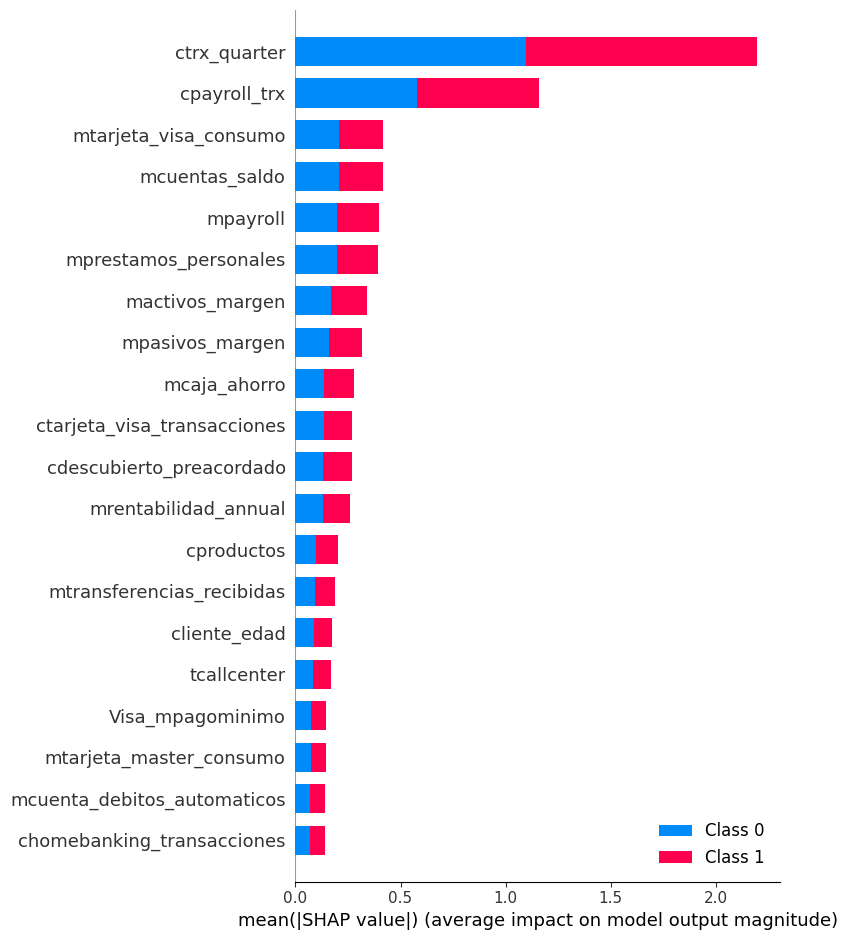

In [13]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

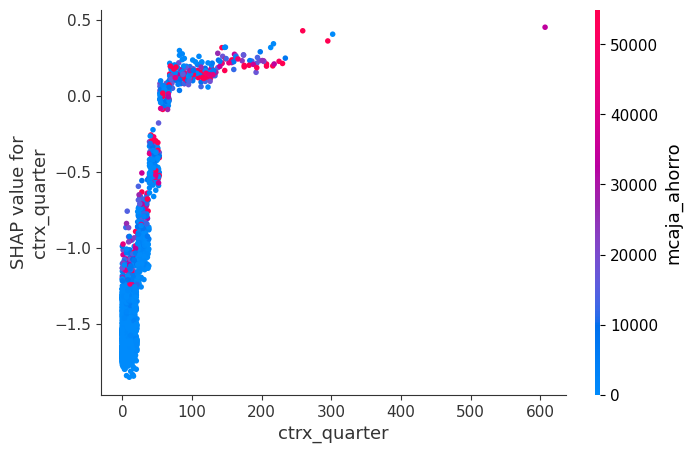

In [14]:
shap.dependence_plot("ctrx_quarter", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [15]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [161]:
embedding_2d = umap.UMAP(
  n_components=5, n_neighbors=40
).fit_transform(shap_values[0])

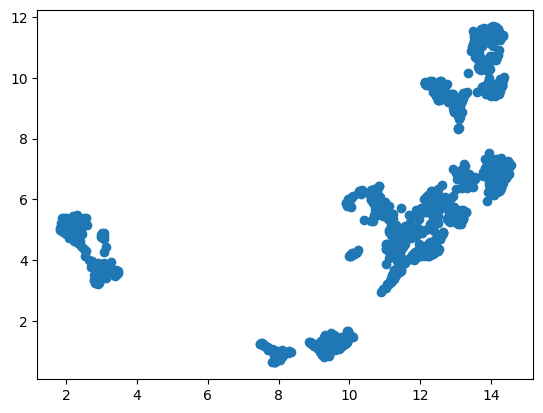

In [162]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [19]:
!pip install hdbscan
#!pip install joblib==1.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
import hdbscan

from hdbscan.flat import HDBSCAN_flat
clusterer = HDBSCAN_flat(embedding_2d,
                         cluster_selection_method='eom',
                         n_clusters=4, min_cluster_size=20)
labels = clusterer.labels_

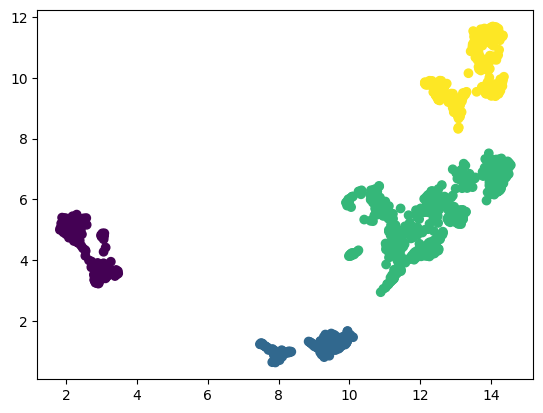

In [175]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [176]:
Xbajas['segmento'] = labels

In [193]:
Xbajas.groupby('segmento').mean()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
segmento,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.156163e+08,202101.0,0.493151,0.000000,0.228311,47.127854,103.415525,1313.005251,13130.926530,692.657306,126.262329,402.593288,5.004566,1.031963,1.000000,-173.629726,-25619.639224,2.059361,5370.873653,0.143105,22573.011553,0.000000,-3063.067808,1.287671,0.091324,94.776575,0.232877,0.283105,527.849315,0.223744,0.054795,193.045114,0.191781,493.122237,0.000000,0.000000,0.091324,16751.159772,0.004566,42849.315068,0.000000,0.009132,6.705160,473.484932,0.000000,0.000000,0.031963,0.004566,0.027397,0.027397,0.009132,0.000000,0.000000,0.000000,0.000000,0.045662,23.004155,0.059361,153.288950,0.013699,88.695525,0.000000,0.000000,0.027397,40.283927,0.004566,0.535616,0.004566,0.963562,0.000000,0.000000,0.506849,564.011096,1.767123,692.658858,0.000000,0.000000,0.000000,0.000000,0.000000,0.173516,1373.403333,0.041096,166.433744,0.018265,73.915068,0.004566,34.81